In [48]:
import os
import pandas as pd
import numpy as np
import top_order_book as tob
import data_parse
import matplotlib.pyplot as plt
import seaborn as sns

from time import process_time

In [51]:
def get_daily_impact_vs_imbalance(daily_trades_info: pd.DataFrame) -> pd.DataFrame:
    """
    Obtain daily aggregated impact versus flow imbalance
    
    Parameters
    ----------    
    daily_trades_info: pd.DataFrame
    
    Returns
    ----------
    dat: pd.DataFrame
    """
    # initialize
    TV = tob.TradeVisualize()
    durations = [5, 10, 20, 50, 100]
    
    # process daily_trades_info for each T
    aggre_info_dict = {duration: TV.get_aggre_info_tick_nonconsec(daily_trades_info, duration)
                  for duration in durations}
    
    # normalization factors
    daily_vol = np.sum(daily_trades_info['TradeVolume'])
    
    R1 = - daily_trades_info['MidPrice'].diff() * daily_trades_info['Buy/Sell']
    R1[0] = 0
    daily_R1 = np.average(R1)
    
    output = pd.DataFrame()
    
    for T in durations:
        aggre_info_dict[T]['qi'] = aggre_info_dict[T]['MidPriceEnd'] - aggre_info_dict[T]['MidPriceBeg']
        dat = aggre_info_dict[T][['qi', 'OrderFlowImba']].groupby(['OrderFlowImba']).mean()
        dat = dat.reset_index()
        
        # normalize
        dat['OrderFlowImba'] /= daily_vol
        dat['qi'] /= daily_R1
        
        # add T column
        dat['T'] = T
        
        # finish
        output = output.append(dat, ignore_index=True)
        
    return output

In [42]:
directory = 'output/'

In [43]:
files = os.listdir(directory)
data = []
for file in files:
    if file.endswith('.csv'):
        f = open(directory + file, 'r')
        data.append(pd.read_csv(f))
        f.close()

In [49]:
t1_start = process_time()
temp1 = get_daily_impact_vs_imbalance(data[1])
t1_stop = process_time()

In [50]:
print(t1_stop - t1_start)  

140.953125


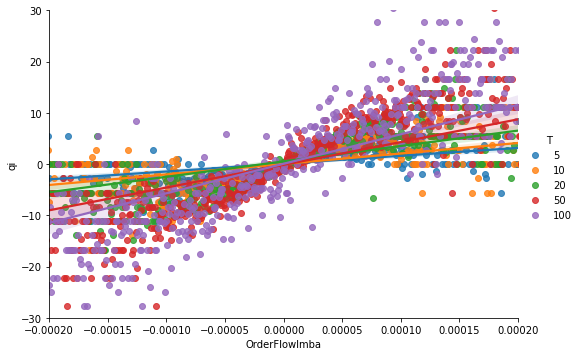

In [38]:
sns.lmplot(x='OrderFlowImba', y='qi', hue='T', data=temp1, aspect=1.5)
plt.xlim(-0.0002, 0.0002)
plt.ylim(-30, 30)
plt.show()

In [65]:
t1_start = process_time()
for idx, file in enumerate(files):
    date_label = file[18:-4]
    impact_vs_imbalance = get_daily_impact_vs_imbalance(data[idx])
    impact_vs_imbalance.to_csv(r"output/impact_vs_imbalance_" + date_label + r".csv")
t1_stop = process_time()

In [66]:
t1_stop - t1_start

4234.609375

In [77]:
directory = 'output/'

files = os.listdir(directory)
data_to_plot = pd.DataFrame()
for file in files:
    if file.startswith(r'impact_vs_imbalance_') & file.endswith('.csv'):
        f = open(directory + file, 'r')
        data_to_plot = data_to_plot.append(pd.read_csv(f, index_col=0), ignore_index=True)
        f.close()

In [78]:
data_to_plot

,OrderFlowImba,qi,T
0,-0.000400,0.000000,5
1,-0.000384,0.000000,5
2,-0.000349,0.000000,5
3,-0.000342,0.000000,5
4,-0.000322,0.000000,5
...,...,...,...
79754,0.000579,17.881553,100
79755,0.000638,23.842070,100
79756,0.000712,23.842070,100
79757,0.000774,59.605176,100


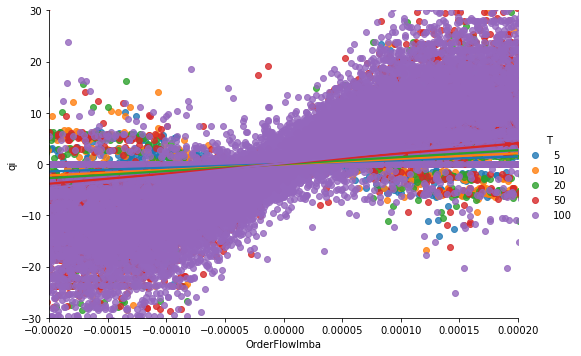

In [79]:
sns.lmplot(x='OrderFlowImba', y='qi', hue='T', data=data_to_plot, aspect=1.5)
plt.xlim(-0.0002, 0.0002)
plt.ylim(-30, 30)
plt.show()

In [80]:
from scipy.optimize import curve_fit

# Define functions for optimization
def scale_function(x, alpha, beta):
    """Scaling function
    """
    return x / np.power(1 + np.power(abs(x), alpha), beta/alpha)

def func(qT, chi, kappa, alpha, beta):
    """Function used for optimization
    """
    q = qT[0]
    T = qT[1]
    x = q / np.power(T, kappa)
    return np.power(T, chi) * scale_function( x, alpha, beta ) 

In [81]:
popt, pcov = curve_fit(func, np.transpose(data_to_plot.iloc[:, 1:].to_numpy()), data_to_plot.iloc[:, 0].to_numpy(), bounds=(0, np.inf))

In [82]:
popt

array([1.40068677, 2.38119924, 0.06646696, 0.96440149])